# Snapshot Graphs
Transmission graphs for an integration. Cleaning WIP

In [4]:
from AD_analysis import *
import Atmospheric_diffraction as atm_shift
import numpy as np

The code mainly draws on the following steps, with key variables described:

>analysis=AD_analysis()

This gets the class

====
>analysis.load_wave('LR','NIR','IY','H',sampling=1 * u.nm) 

This function loads the wavelengths that will be used for the shift calculations. 

First variable is LR or HR

Second variable is NIR or VIS

Third/fourth variables are the start/end bands. These can be the same, e.g. 'B', 'B'.

====
>analysis.load_airmasses(ZA_range=[0,10,20,30,40,50,60])

OR
>analysis.load_airmasses(HA_range=[0,1,2],targ_dec= 0 * u.degree)
This function loads the airmasses to calculate the shifts for.

Can use 1) zenith angles (ZA_range)
OR 2) hour angles (HA_range); the declination is -25.3 deg by default, change with targ_dec=X

====
>analysis.calculate_shifts(fibrecentre_waveref = 1.1 * u.micron,reposition=True, guide_waveref=5 * u.micron)

This function calculates the shifts for the generated wavelengths and airmasses

fibrecentre_waveref is the aperture wavelength reference for original position

guide_waveref is the telescope guiding wavelength reference

reposition = TRUE or FALSE is a setting that determines whether the fibre is aligned on the aperture wavelength reference for each sequential airmass

====
>analysis.calculate_transmissions(method="numerical moffat") 

This function calculates the transmissions for the shifts using one of several methods

method can be 1) analytical gaussian, 2) numerical gaussian, 3) numerical moffat, or 4) numerical durham

====

These functions can be used in many ways for different plots/analysis of transmissions/shifts

Most of these function have other optional variables, e.g., scale for the numerical simulations, whether to change FWHM with airmass and wavelength. These are described in the relevant function notes

In [5]:
#This function is used to calculate the average transmission over an integration.
#It takes the transmissions for each wavelength from multiple airmasses and averages them.
#This only is a true average of an integration if equally spaced HA have been used.
#This is not true with ZA, as ZA does not increase linearly with time
def observation_transmission(output_parameters):
    integ_transmission=[]
    for i in range(0,len(output_parameters['wave_wavelengths'])):
        trans=0
        for o in range(0,len(output_parameters['wave_transmissions'])):
            trans=trans+output_parameters['wave_transmissions'][o][i]
        trans_mean=trans/len(output_parameters['wave_transmissions'])
        integ_transmission.append(trans_mean)
    return integ_transmission

## Integration Transmission Graphs
### Transmission vs Wavelength for various aperture centres

In [11]:
#Following function plots integration transmission average for single mode observations
def plot_integ_trans(fibres,guide,analysis,normalise="none",method="numerical moffat"):  
    """
    normalise: string, "none", "no ad"
        what to normalise the transmission to; either no normalisation, or relative to the no AD case (perfect ADC)

    """
    weights = np.arange(0, len(fibres)+1)
    norm = mpl.colors.Normalize(vmin=min(weights), vmax=max(weights))
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.RdBu)

    integ_transmissions=[]
    for fibre_val in fibres:
        analysis.calculate_shifts(fibrecentre_waveref = fibre_val,reposition=False, guide_waveref=guide)
        analysis.calculate_transmissions(method=method)
        integ_transmission=observation_transmission(analysis.output_parameters)
        integ_transmissions.append(integ_transmission)


    for i in range(0,len(analysis.output_parameters['shifts'])):
        for o in range(0,len(analysis.output_parameters['shifts'][i])):
            analysis.output_parameters['shifts'][i][o]=0
    analysis.calculate_transmissions(method=method)
    opt_transmission=observation_transmission(analysis.output_parameters)

    plt.figure(figsize=[7,5])
    if normalise == "none":
        for count,i in enumerate(integ_transmissions):
            plt.plot(analysis.output_parameters['wave_wavelengths'],np.array(i),label='Aperture Centre = {}'.format(fibres[count]),color=cmap.to_rgba(len(fibres)-count))
        plt.ylabel("Mean Transmission")        
        plt.plot(analysis.output_parameters['wave_wavelengths'],opt_transmission,label='No AD Transmission',color='black',linestyle='--')
    if normalise == "no AD":
        for count,i in enumerate(integ_transmissions):
            plt.plot(analysis.output_parameters['wave_wavelengths'],np.array(i)/np.array(opt_transmission),label='Aperture Centre = {}'.format(fibres[count]),color=cmap.to_rgba(len(fibres)-count))
        plt.axhline(y=1,label='No AD Transmission',color='black',linestyle='--')
        plt.ylabel("Mean Transmission Relative to No AD")
        
    plt.legend()
    plt.ylim(0,1.1)
    plt.xlabel("Wavelength (nm)")
    if analysis.input_parameters['HA_range'] != []:
        plt.title("{} {}, Guiding = {}, HA {}-{}h, Dec = {}".format(analysis.input_parameters['regime'],analysis.input_parameters['band'],guide,analysis.input_parameters['HA_range'][0],analysis.input_parameters['HA_range'][-1],analysis.input_parameters['targ_dec']))
    else:
        plt.title("{} {}, Guiding = {}, Airmass {}-{}".format(analysis.input_parameters['regime'],analysis.input_parameters['band'],guide,analysis.output_parameters['airmasses'][0],analysis.output_parameters['airmasses'][-1]))


HA used
Target goes below Horizon above/below HA of +/- 6.0h


/opt/anaconda3/envs/astrocondatest/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


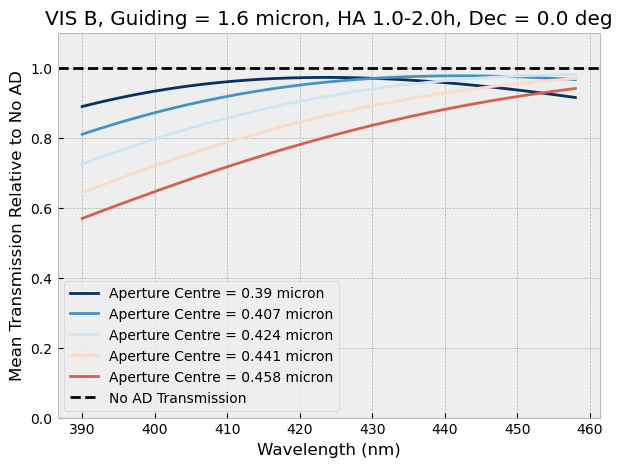

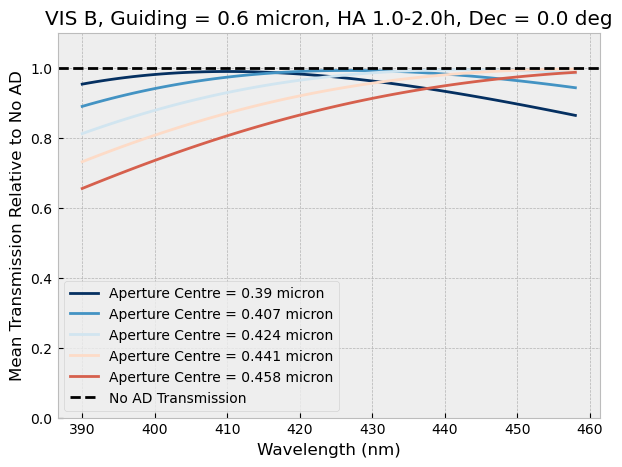

In [12]:
#Following is what is needed to plot the Trans vs Wavelength graphs for various aperture centres
#VIS
analysis=AD_analysis()
analysis.load_wave('LR','VIS','B','B') #Change for wanted observing mode

#Use either airmasses directly or HA; HA is more sensible as it actually scales linearly with time.
#Airmasses directly:
#analysis.load_airmasses(airmasses=np.linspace(1.1,1.3,21))

#HA:
analysis.load_airmasses(HA_range=np.linspace(1,2,21),targ_dec=0*u.deg)

#Aperture values to use:
fibres=np.around(np.linspace(min(analysis.output_parameters['wave_wavelengths']).to(u.micron).value,max(analysis.output_parameters['wave_wavelengths']).to(u.micron).value,5)*u.micron,3)

#Guide in NIR:
guide=1.6 * u.micron
plot_integ_trans(fibres,guide,analysis,method="numerical moffat",normalise="no AD")

#Guide in VIS:
guide=.6 * u.micron
plot_integ_trans(fibres,guide,analysis,method="numerical moffat",normalise="no AD")


HA used
Target goes below Horizon above/below HA of +/- 6.0h


/opt/anaconda3/envs/astrocondatest/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


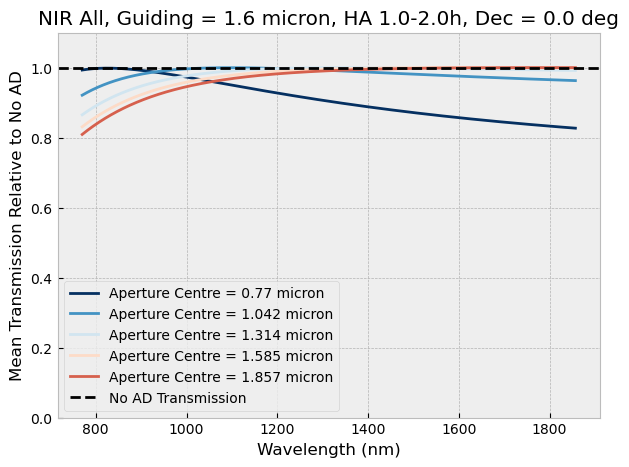

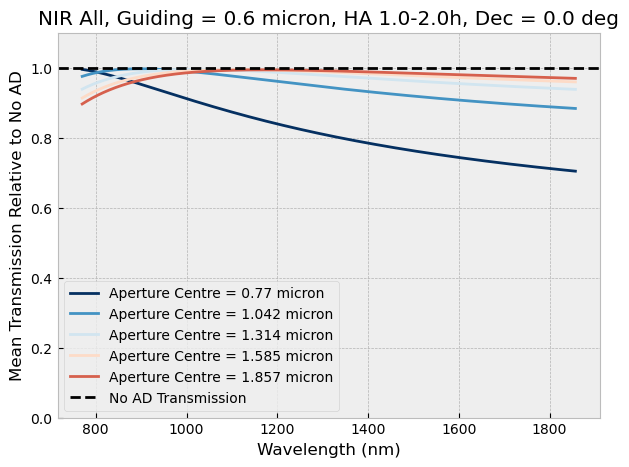

In [8]:
#NIR
analysis=AD_analysis()
analysis.load_wave('LR','NIR','IY','H')

#Use either airmasses directly or HA; HA is more sensible as it actually scales linearly with time.
#Airmasses directly:
#analysis.load_airmasses(airmasses=np.linspace(1.1,1.3,21))

#HA:
analysis.load_airmasses(HA_range=np.linspace(1,2,21),targ_dec=0*u.deg)

fibres=np.around(np.linspace(min(analysis.output_parameters['wave_wavelengths']).to(u.micron).value,max(analysis.output_parameters['wave_wavelengths']).to(u.micron).value,5)*u.micron,3)

guide=1.6 * u.micron
plot_integ_trans(fibres,guide,analysis,method="numerical moffat",normalise="no AD")

guide=.6 * u.micron
plot_integ_trans(fibres,guide,analysis,method="numerical moffat",normalise="no AD")

### Parallel Mode Graph

In [2]:
#Following function plots integration transmission average for parallel observations
def plot_integ_trans_parallel(VIS_fibres,NIR_fibres,VIS_mode,NIR_mode,guide,analysis,normalise="none",method="numerical moffat"):  
    weights_r = np.arange(0, len(NIR_fibres)+2)
    norm_r = mpl.colors.Normalize(vmin=min(weights_r), vmax=max(weights_r))
    cmap_red = mpl.cm.ScalarMappable(norm=norm_r, cmap=mpl.cm.Reds)
    weights_b = np.arange(0, len(VIS_fibres)+2)
    norm_b = mpl.colors.Normalize(vmin=min(weights_b), vmax=max(weights_b))
    cmap_blue = mpl.cm.ScalarMappable(norm=norm_b, cmap=mpl.cm.Blues)
    
    analysis.load_wave(VIS_mode[0],VIS_mode[1],VIS_mode[2],VIS_mode[3])
    integ_transmissions=[]
    
    for fibre_val in VIS_fibres:
        analysis.calculate_shifts(fibrecentre_waveref = fibre_val,reposition=False, guide_waveref=guide)
        analysis.calculate_transmissions(method=method)
        integ_transmission=observation_transmission(analysis.output_parameters)
        integ_transmissions.append(integ_transmission)
    
    for i in range(0,len(analysis.output_parameters['shifts'])):
        for o in range(0,len(analysis.output_parameters['shifts'][i])):
            analysis.output_parameters['shifts'][i][o]=0
    analysis.calculate_transmissions(method=method)
    opt_transmission=observation_transmission(analysis.output_parameters)

    plt.figure(figsize=[7,5])
    if normalise == "none":
        for count,i in enumerate(integ_transmissions):
            plt.plot(analysis.output_parameters['wave_wavelengths'],np.array(i),label='Aperture Centre = {}'.format(VIS_fibres[count]),color=cmap_blue.to_rgba(len(VIS_fibres)-count))

        plt.plot(analysis.output_parameters['wave_wavelengths'],opt_transmission,label='No AD Transmission',color='black',linestyle='--')
    if normalise == "no AD":
        for count,i in enumerate(integ_transmissions):
            plt.plot(analysis.output_parameters['wave_wavelengths'],np.array(i)/np.array(opt_transmission),label='Aperture Centre = {}'.format(VIS_fibres[count]),color=cmap_blue.to_rgba(len(VIS_fibres)-count))

    analysis.load_wave(NIR_mode[0],NIR_mode[1],NIR_mode[2],NIR_mode[3])

    integ_transmissions=[]
    for fibre_val in NIR_fibres:
        analysis.calculate_shifts(fibrecentre_waveref = fibre_val,reposition=False, guide_waveref=guide)
        analysis.calculate_transmissions(method=method)
        integ_transmission=observation_transmission(analysis.output_parameters)
        integ_transmissions.append(integ_transmission)

    for i in range(0,len(analysis.output_parameters['shifts'])):
        for o in range(0,len(analysis.output_parameters['shifts'][i])):
            analysis.output_parameters['shifts'][i][o]=0
    analysis.calculate_transmissions(method=method)
    opt_transmission=observation_transmission(analysis.output_parameters)


    if normalise == "none":
        for count,i in enumerate(integ_transmissions):
            plt.plot(analysis.output_parameters['wave_wavelengths'],np.array(i),label='Aperture Centre = {}'.format(NIR_fibres[count]),color=cmap_red.to_rgba(len(NIR_fibres)-count))
        plt.ylabel("Mean Transmission")        
        plt.plot(analysis.output_parameters['wave_wavelengths'],opt_transmission,label='No AD Transmission',color='black',linestyle='--')
    if normalise == "no AD":
        for count,i in enumerate(integ_transmissions):
            plt.plot(analysis.output_parameters['wave_wavelengths'],np.array(i)/np.array(opt_transmission),label='Aperture Centre = {}'.format(NIR_fibres[count]),color=cmap_red.to_rgba(len(NIR_fibres)-count))
        plt.axhline(y=1,label='No AD Transmission',color='black',linestyle='--')
        
        plt.ylabel("Mean Transmission Relative to No AD")
        
    plt.ylim(0,1.1)
    plt.xlabel("Wavelength (nm)")
    plt.axvline(x=guide.value*1000,color='black',linewidth=0.7,label='Guiding Wavelength')
    if analysis.input_parameters['HA_range'] != []:
        plt.title("VIS {} + NIR {}, Guiding = {}, HA {}-{}, Dec = {}".format(VIS_mode[2],analysis.input_parameters['band'],guide,analysis.input_parameters['HA_range'][0],analysis.input_parameters['HA_range'][-1],analysis.input_parameters['targ_dec']))
    else:
        plt.title("{} {}, Guiding = {}, Airmass {}-{}".format(analysis.input_parameters['regime'],analysis.input_parameters['band'],guide,analysis.output_parameters['airmasses'][0],analysis.output_parameters['airmasses'][-1]))
    plt.legend()

Target goes below Horizon above/below HA of +/- 6.0h
[1.1388696  1.14297633 1.14731009 1.15187496 1.15667527 1.16171566
 1.16700099 1.17253647 1.17832757 1.18438011 1.19070021 1.19729438
 1.20416948 1.21133274 1.21879181 1.22655479 1.23463019 1.24302703
 1.25175482 1.2608236  1.27024398]


/opt/anaconda3/envs/astrocondatest/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


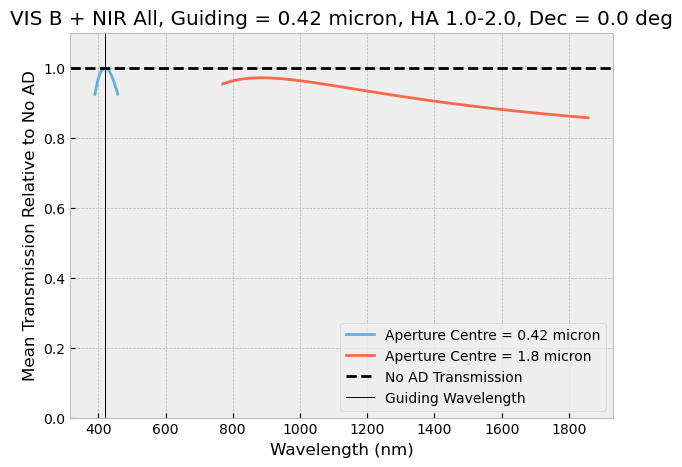

In [17]:
analysis=AD_analysis()

analysis.load_airmasses(HA_range=np.linspace(1,2,21),targ_dec=0*u.deg)
print(analysis.output_parameters['airmasses'])
plot_integ_trans_parallel([0.42]*u.micron,[1.8]*u.micron,["LR","VIS","B","B"],["LR","NIR","IY","H"],.42*u.micron,analysis,normalise="no AD")

[1.1  1.11 1.12 1.13 1.14 1.15 1.16 1.17 1.18 1.19 1.2  1.21 1.22 1.23
 1.24 1.25 1.26 1.27 1.28 1.29 1.3 ]
[1.1388696  1.14297633 1.14731009 1.15187496 1.15667527 1.16171566
 1.16700099 1.17253647 1.17832757 1.18438011 1.19070021 1.19729438
 1.20416948 1.21133274 1.21879181 1.22655479 1.23463019 1.24302703
 1.25175482 1.2608236  1.27024398]


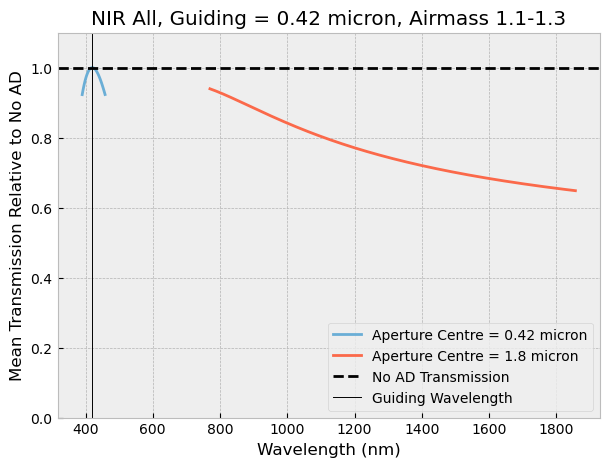

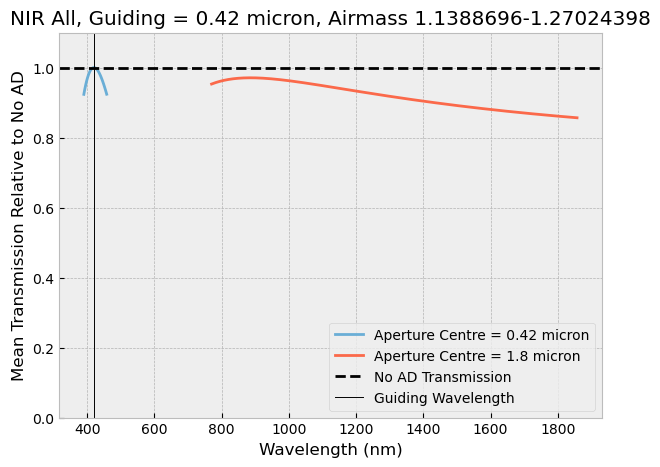

In [19]:
analysis=AD_analysis()

analysis.load_airmasses(airmasses=np.linspace(1.1,1.3,21),targ_dec=0*u.deg)
print(analysis.output_parameters['airmasses'])
plot_integ_trans_parallel([0.42]*u.micron,[1.8]*u.micron,["LR","VIS","B","B"],["LR","NIR","IY","H"],.42*u.micron,analysis,normalise="no AD")

analysis=AD_analysis()

analysis.load_airmasses(airmasses=[1.1388696,1.14297633,1.14731009,1.15187496,1.15667527,1.16171566
,1.16700099,1.17253647,1.17832757,1.18438011,1.19070021,1.19729438
,1.20416948,1.21133274,1.21879181,1.22655479,1.23463019,1.24302703
,1.25175482,1.2608236,1.27024398],targ_dec=0*u.deg)
print(analysis.output_parameters['airmasses'])
plot_integ_trans_parallel([0.42]*u.micron,[1.8]*u.micron,["LR","VIS","B","B"],["LR","NIR","IY","H"],.42*u.micron,analysis,normalise="no AD")

 

Durham Version

HA used
Target goes below Horizon above/below HA of +/- 6.0h


/opt/anaconda3/envs/astrocondatest/lib/python3.7/site-packages/ipykernel_launcher.py:65: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


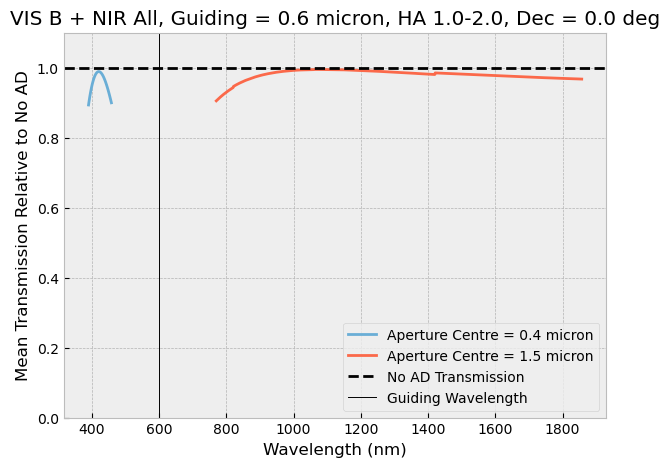

In [19]:
#Same as above, but uses Durham PSFs
analysis=AD_analysis()

analysis.load_airmasses(HA_range=np.linspace(1,2,21),targ_dec=0*u.deg)

plot_integ_trans_parallel([0.4]*u.micron,[1.5]*u.micron,["LR","VIS","B","B"],["LR","NIR","IY","H"],.6*u.micron,analysis,normalise="no AD",method="numerical durham")

## Spreadsheet ADC Transmissions
Calculation of transmissions for specific shifts from an ADC system for Myriam

In [15]:
import Transmission_calculation as trans
Plate_Scale = 3.316 # [mm/arcsec]
Plate_Scale = Plate_Scale*1000 #um/arcsec
lambdas=[770,859,1010,1045,1370,1420,1670,1926]*u.nm
shifts_0=[0,0,0,0,0,0,0,0] #is in um
shifts_30=np.array([212,141,60,50,35,42,100,195])
shifts_45=np.array([366,243,104,87,61,72,173,338])
shifts_50=np.array([436,289,124,103,72,86,205,402])
shifts_60=np.array([633,420,179,150,105,125,298,584])
shifts=np.array([shifts_0,shifts_30,shifts_45,shifts_50,shifts_60])/Plate_Scale*u.arcsec


In [16]:
analysis=AD_analysis()
analysis.output_parameters['wave_wavelengths']=lambdas
analysis.load_airmasses(ZA_range=[0,30,45,50,60])
analysis.output_parameters['shifts']=shifts
analysis.output_parameters['fibre_diameter']=0.6*u.arcsec
analysis.calculate_transmissions(k_lim=30, FWHM_change=True, kolb_factor=True, method="numerical moffat",scale=0.001)

raw_trans=analysis.output_parameters['wave_transmissions']

ZA_vals=[0,30,45,50,60]
analysis=AD_analysis()
analysis.output_parameters['wave_wavelengths']=lambdas

analysis.output_parameters['shifts']=[shifts_0]*u.arcsec
analysis.output_parameters['fibre_diameter']=0.6*u.arcsec
for i in range(0,len(ZA_vals)):
    analysis.load_airmasses(ZA_range=[ZA_vals[i]])
    analysis.calculate_transmissions(k_lim=30, FWHM_change=True, kolb_factor=True, method="numerical moffat",scale=0.001)
    print("Raw Transmission for ZA = {} for ADC shifts:".format(ZA_vals[i]))
    rounded_vals = [ round(val,3) for val in raw_trans[i]]
    print(rounded_vals)
    normalised_vals=(np.array(raw_trans)[i]/np.array(analysis.output_parameters['wave_transmissions'][0]))
    print("Transmission relative to no AD for ZA = {} for ADC shifts:".format(ZA_vals[i]))
    normalised_vals = [round(elem,3) for elem in normalised_vals]
    print(normalised_vals)
    print("==========================================================")
    

Zenith Angles Used
Zenith Angles Used
Raw Transmission for ZA = 0 for ADC shifts:
[0.425, 0.444, 0.472, 0.478, 0.531, 0.538, 0.572, 0.604]
Transmission relative to no AD for ZA = 0 for ADC shifts:
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Zenith Angles Used
Raw Transmission for ZA = 30 for ADC shifts:
[0.369, 0.39, 0.42, 0.426, 0.476, 0.483, 0.514, 0.537]
Transmission relative to no AD for ZA = 30 for ADC shifts:
[0.98, 0.991, 0.998, 0.999, 0.999, 0.999, 0.995, 0.98]
Zenith Angles Used
Raw Transmission for ZA = 45 for ADC shifts:
[0.296, 0.32, 0.351, 0.356, 0.402, 0.408, 0.434, 0.443]
Transmission relative to no AD for ZA = 45 for ADC shifts:
[0.947, 0.975, 0.995, 0.997, 0.998, 0.998, 0.985, 0.943]
Zenith Angles Used
Raw Transmission for ZA = 50 for ADC shifts:
[0.266, 0.29, 0.32, 0.326, 0.369, 0.375, 0.398, 0.4]
Transmission relative to no AD for ZA = 50 for ADC shifts:
[0.93, 0.967, 0.994, 0.996, 0.998, 0.997, 0.98, 0.923]
Zenith Angles Used
Raw Transmission for ZA = 60 for ADC shifts